# Adversarial Attack 

- develop a model for mnist dataset using fastai
- attack the model using foolbox (black box attack)
- check the density & coverage metrics

In [1]:
# dependencies
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import numpy as np
from n2gem.metrics import gem_build_coverage, gem_build_density
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import torchvision
from fastai.vision.all import *
from fastai.vision import *

In [3]:
import medmnist
from medmnist import INFO, Evaluator

Fix the seed generator

In [4]:
torch.manual_seed(42) 
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device); print(torch.cuda.memory_allocated())
torch.cuda.device_count()

cuda
0


1

### Import the MNIST dataset 

In [30]:
def load_mnist():
    """Function to load the mnist
        The following transform is aaplied: Normalize:(0.1307,)(0.3081,)
    
    """
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
        #torchvision.transforms.Normalize((0.1307,), (0.3081))
    ])
    train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
    test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)
    
    return train_set, test_set

train_set, test_set = load_mnist()

### Import the MEDMNIST dataset 

In [115]:
#from torch.utils.data import Dataset
data_transform = torchvision.transforms.Compose([
    #torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.74,0.53,0.71), (0.12,0.18,0.13))
    #torchvision.transforms.Normalize((0.5,0.5, 0.5), (0.5,0.5,0.5))
])

class LoadMed(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform):
        
        self.images = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        
        img, target = self.images[idx], self.labels[idx].astype(int)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target
        
        

npz_file = np.load('/home/venkat31/.medmnist/pathmnist.npz')

train_imgs = npz_file['train_images']
test_imgs = npz_file['test_images']
val_imgs = npz_file['val_images']

train_labels = npz_file['train_labels']
test_labels = npz_file['test_labels']
val_labels = npz_file['val_labels']

In [116]:
arr_X_dataset = np.concatenate([train_imgs, test_imgs, val_imgs])
arr_Y_dataset = np.concatenate([train_labels, test_labels, val_labels])

In [117]:
dataset = LoadMed(arr_X_dataset, arr_Y_dataset, data_transform)

-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------

### Combine the datasets and stratify split 
- Combine train and test
- form the model_dataset[training+ test] and validation set
- obtain training & test set to train on the model from model_dataset

In [31]:
from torch.utils.data import ConcatDataset
from sklearn.model_selection import train_test_split

def create_dataset(dataset, vali_split, test_split, train_set=None, test_set=None):
    """Function to split the dataset and form the training, test and validation datasets
        
        Parameters
        ----------------------
        train_set: torch.utils.mnist.dataset
        test_set: torch.utils.mnist.dataset
        vali_split: the size for the validation set 
        test_split: the size of the test set
        
        Return
        ----------------------
        X_trainset: list, size: train_size, 1, 28, 28
        X_testset: list, size: test_size, 1, 28, 28
        X_validation: list, size: vali_size, 1, 28, 28
        y_trainset: list, size: train_size
        y_testset: list, size: test_size
        y_valiset: list, size: vali_size
        
    """
    # combine the datasets
    if not dataset:
        dataset = ConcatDataset([train_set, test_set])
    
    X=[]; Y=[];
    for i in range(len(dataset)):
        x, y = dataset[i]
        X.append(x.numpy())  #.detach().cpu().numpy())
        Y.append(y)
    
    # split the dataset into train and validation set
    X_model, X_validation, y_model, y_validation = train_test_split(X, Y, test_size=vali_split, random_state=42, stratify=np.array(Y))

    print("X_validation_set size: ", np.array(X_validation).shape)
    print("Y_validation_set size: ", len(y_validation))
    
    # split the X_model, y_model into training set & test set
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_model, y_model, test_size=test_split, random_state=42, stratify=np.array(y_model))
    print("X_train_set size: ", np.array(X_trainset).shape)
    print("Y_train_set size: ", len(y_trainset))
    print("X_test_set size: ", np.array(X_testset).shape)
    print("Y_test_set size: ", len(y_testset))
    
    #X = np.array(X); Y = np.array(Y)
    
    return X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation

X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(False, 0.03, 0.2, train_set=train_set, test_set=test_set)

X_validation_set size:  (2100, 1, 28, 28)
Y_validation_set size:  2100
X_train_set size:  (54320, 1, 28, 28)
Y_train_set size:  54320
X_test_set size:  (13580, 1, 28, 28)
Y_test_set size:  13580


### Convert the datasets to Torch.TensorDataset

In [32]:
def convert_tensor(X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation):
    """
    Function to convert the split datasets into torch Tensor dataset
    
    Parameters
    ----------------------
    X_trainset: list, size: train_size, 1, 28, 28
    X_testset: list, size: test_size, 1, 28, 28
    X_validation: list, size: vali_size, 1, 28, 28
    y_trainset: list, size: train_size
    y_testset: list, size: test_size
    y_valiset: list, size: vali_size
    
    Return
    -------------------
    train_set: TensorDataset, consists of training images and labels
    test_set: TensorDataset, consists of test images and labels
    validation_set: TensorDataset, consists of validation images and labels
    
    # for the adversarial attack
    model_dataset_images: Tensor, size: (training + test) size, only the images
    model_dataset_images: Tensor, size: (training + test) size, only the labels
    """
    X_trainset = torch.Tensor(X_trainset); 
    y_trainset = torch.Tensor(y_trainset).type(torch.LongTensor).view(-1) #dtype = torch.long);
    X_testset = torch.Tensor(X_testset); 
    y_testset = torch.Tensor(y_testset).type(torch.LongTensor).view(-1);
    X_validation = torch.Tensor(X_validation); 
    y_validation = torch.Tensor(y_validation).type(torch.LongTensor).view(-1)
    # y - label should be longTensor for fastai training
    
    # form model_dataset
    model_dataset_images = torch.vstack((X_trainset, X_testset))
    model_dataset_labels = torch.cat((y_trainset, y_testset))
    
    # form the Tensor dataset
    train_set = torch.utils.data.TensorDataset(X_trainset, y_trainset)
    test_set = torch.utils.data.TensorDataset(X_testset, y_testset)
    validation_set = torch.utils.data.TensorDataset(X_validation, y_validation)
    
    return train_set, test_set, validation_set, model_dataset_images, model_dataset_labels

train_set, test_set, validation_set, model_images, model_labels = convert_tensor(X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation)

In [150]:
torch.save(model_images, 'pathmnist_model_images.pt')
torch.save(model_labels, 'pathmnist_model_labels.pt')

In [151]:
torch.save(X_validation, 'pathmnist_validation_images.pt')
torch.save(y_validation, 'pathmnist_validation_labels.pt')

### The Dataloader for the CNN models

In [33]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)

### Define the CNN model

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=7)
        #self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        #self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*11*11, 128)
        #self.fc3 = nn.Linear(512, 32)
        self.fc4 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        #x = self.drop(self.conv2(x))
        #x = self.conv2(x)
        #x = F.relu(F.max_pool2d(x, 2))
        #print(x.shape)
        x = x.view(-1, 4*11*11)
        x = F.relu(self.fc1(x))
        #x = self.drop(x)
        #x = F.relu(self.fc3(x))
        #x = self.drop(x)
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [194]:
import torch.nn as nn
# for overfit model: dropout is removed and trained for 50 epochs
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 9))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

Get the parameteres from the model

In [195]:
model = NewNet()
#model1 = CNet()
param = [p for p in list(model.parameters()) if p.requires_grad]
uniq = {p.data_ptr(): p for p in list(model.parameters())}.values()
print(sum(p.numel() for p in uniq))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
#print(sum(p.numel() for p in model1.parameters() if p.requires_grad))

243049
243049


### Fastai classifier
- Fastai takes the available device by default

In [202]:
data = DataLoaders(train_loader, test_loader)
path_learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)
#learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)
#learn1 = Learner(data, CNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)

In [203]:
path_learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.467670,0.800099,0.735576,00:08
1,0.259533,0.346553,0.881660,00:09
2,0.158161,0.147844,0.950012,00:09


SuggestedLRs(valley=tensor(0.0003))

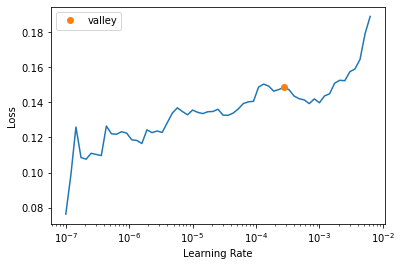

In [204]:
path_learn.unfreeze()
path_learn.lr_find()

In [205]:
path_learn.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.156346,0.146273,0.951142,00:08
1,0.153720,0.142372,0.951780,00:09
2,0.148023,0.142497,0.951731,00:08
3,0.125648,0.143216,0.952369,00:09
4,0.120111,0.128908,0.958704,00:09
5,0.112172,0.128107,0.957722,00:09
6,0.100891,0.122415,0.960962,00:09
7,0.099023,0.121271,0.961208,00:09
8,0.097881,0.117555,0.962043,00:09
9,0.087523,0.117352,0.962632,00:09


In [207]:
path_learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.330774,0.301458,0.898748,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.209868,0.267495,0.909403,00:08
1,0.201216,0.202667,0.932188,00:09
2,0.136318,0.153114,0.950012,00:09
3,0.099699,0.114648,0.961650,00:09
4,0.068727,0.098741,0.969015,00:09


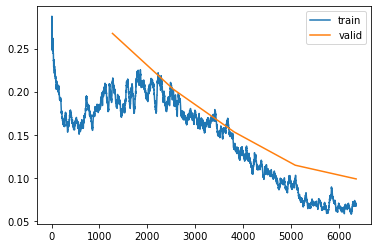

In [208]:
path_learn.recorder.plot_loss()

## ResNet models 

In [86]:
data = DataLoaders(train_loader, test_loader)
resmodel = models.resnet34(num_classes=10)
resmodel.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7)
#model.fc = torch.nn.Linear(512, 10)
#print(model)

In [87]:
print(sum(p.numel() for p in resmodel.parameters() if p.requires_grad))

21283594


In [88]:
# resnet model for training 
learn = Learner(data, resmodel, loss_func=CrossEntropyLossFlat(), opt_func=Adam, metrics=accuracy)

In [89]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.140998,0.131412,0.962887,00:18
1,0.049633,0.111233,0.970250,00:18
2,0.038401,0.037470,0.989323,00:18
3,0.016291,0.019641,0.993888,00:18
4,0.008047,0.016746,0.994845,00:18


In [92]:
learn.save('./fastai_resnet34')
model_new = learn.load('fastai_resnet34')
torch.save(model_new.model.state_dict(), 'fastai_resnet34_weights.pt')

In [111]:
#learn.fit(30)

- Initial fit for the model

In [114]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,0.315950,0.306789,0.912297,00:03
1,0.165154,0.159734,0.953093,00:03
2,0.097478,0.092330,0.972018,00:03
3,0.068718,0.060984,0.981885,00:03
4,0.052096,0.051989,0.983505,00:04
5,0.052169,0.047056,0.985272,00:03
6,0.035102,0.036929,0.988513,00:03
7,0.028907,0.033353,0.990133,00:03
8,0.025092,0.038318,0.988365,00:03
9,0.020819,0.041170,0.988144,00:03


In [119]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,-2010.893433,-2393.189697,0.980854,00:14


epoch,train_loss,valid_loss,accuracy,time
0,-4762.945312,-5056.454102,0.987408,00:14
1,-9382.788086,-9654.258789,0.989396,00:14
2,-10707.206055,-10771.859375,0.993962,00:14


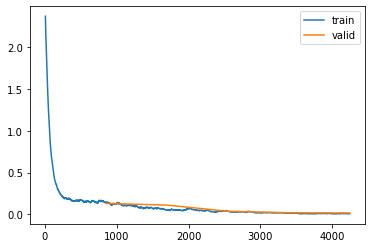

In [91]:
#lss = learn.recorder.losses
#plt.plot(lss)
learn.recorder.plot_loss()
plt.savefig('resnet34_mnist.png')

In [97]:
learn1.fit_one_cycle(3, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.089051,2.061274,0.600589,00:02
1,1.633292,1.615470,0.768851,00:02
2,1.520177,1.517953,0.777982,00:02


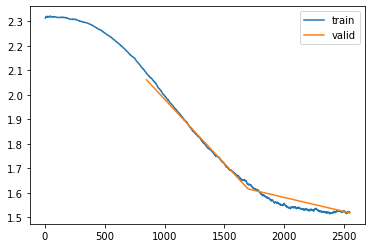

In [99]:
learn1.recorder.plot_loss()
plt.savefig('underfit_loss_3epochs.png')

- Unfreeze and check the optimal learning rate

SuggestedLRs(valley=tensor(0.0044))

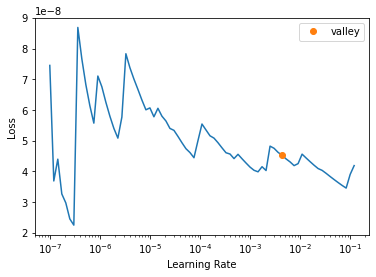

In [182]:
learn.unfreeze()
learn.lr_find()

- Fit the model again

In [139]:
learn.fit_one_cycle(30, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.012687,0.029881,0.990427,00:03
1,0.015406,0.029705,0.990722,00:03
2,0.020524,0.029592,0.990648,00:03
3,0.013447,0.029669,0.990501,00:03
4,0.012682,0.029653,0.990353,00:02
5,0.013864,0.029601,0.990353,00:03
6,0.011523,0.029591,0.990427,00:02
7,0.017564,0.029678,0.990648,00:03
8,0.014337,0.029848,0.990059,00:03
9,0.011938,0.029618,0.990427,00:03


In [56]:
learn.validate()

(#2) [0.0669793039560318,0.9913107752799988]

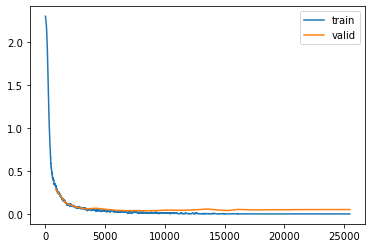

In [189]:
learn.recorder.plot_loss()
#plt.savefig('loss.png')

- Fine tune the model 

In [17]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.120263,0.065498,0.979750,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.064480,0.040627,0.987629,00:03
1,0.069494,0.044321,0.986230,00:03
2,0.051842,0.032422,0.989691,00:03
3,0.047426,0.030197,0.991090,00:03
4,0.035231,0.029030,0.991164,00:03


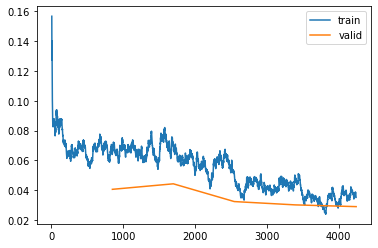

In [18]:
learn.recorder.plot_loss()

### - Save the fastai classifier
- By default it is saved in the /models folder with .pth extension

In [173]:
learn.save('./fastai_resnet50_splitDataset')

Path('models/fastai_resnet50_splitDataset.pth')

In [209]:
path_learn.save('./fastai_pathmnist_96_NewNet')

Path('models/fastai_pathmnist_96_NewNet.pth')

- Load the model(fastai) and save it as torch model for foolbox compatibility

In [24]:
model_new = learn.load('fastai_cnn_NewNet_99_splitDataset')
torch.save(model_new.model.state_dict(), 'fastai_cnn_NewNet_99_splitDataset_weights.pth')

In [210]:
model_new1 = path_learn.load('fastai_pathmnist_96_NewNet')
torch.save(model_new1.model.state_dict(), 'fastai_pathmnist_96_NewNet_weights.pt')

---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------

### Load model for the attack

In [111]:
# load the NewNet model
#MyModel = NewNet()
#MyModel = CNet()
MyModel = models.resnet50(num_classes=10)
MyModel.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7)
MyModel.load_state_dict(torch.load('./fastai_resnet50_weights.pt', map_location=device))
MyModel.eval()
#print(torch.cuda.memory_allocated())
#print(MyModel)
# load the CNet model
#MyModel_1 = CNet()
#MyModel_1.load_state_dict(torch.load('fastai_cnn_weights.pth'))
#MyModel_1.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

### Create a Pytorch model for foolbox attack

In [94]:
preprocess = dict(mean=0.1307, std=0.3081)
bound = (0, 1)
original_model = fb.PyTorchModel(MyModel, bounds=bound, preprocessing=preprocess)

- Three different attacks with 100 values of epsilons

In [41]:
#attack0 = fb.attacks.LinfPGD()
#attack1 = fb.attacks.BoundaryAttack()
attack2 = fb.attacks.FGSM()
#attack = [attack0, attack1, attack2]
epsilon = np.linspace(0.0, 1, num=20)

- Attack the ```trained network``` with model_dataset

In [42]:
def model_attack(attk, model, images, labels, epsilon):
    """
    Function to perform the adv attack on the pytorch model
    
    Parameters
    --------------------
    attk: type of foolbox attack
    model: foolbox Pytorch model
    image: the images used for the attack, either as ep.tensor or torch.tensor
            size:(no_of_samples x dims)
    labels: corresponding labels for the images, either as ep.tensor or torch.tensor
            size:(no_of_samples 
    epsilon: the pertubation
    
    Return
    -------------
    clip_adv: list, the actual adversarial examples generated for the given model
                size: similar to the input images
    adv_ : boolean list, indicating whether a given image is adversarial example or not,
            True - adversarial sample
            False - not an adversarial sample
    """
    raw_adv, clip_adv, adv_ = attk(model, images, labels, epsilons=epsilon)
    
    return clip_adv, adv_


## Attack the model using 20 epsilon & ```FGSM attack```

- Attack the model using validation_dataset (2100 images)
- The model_dataset has 20000 images, selected using stratify split

#### Load the the images

In [14]:
md_images = torch.load('images/model_dataset_images.pt', map_location='cpu').cpu()
md_labels = torch.load('images/model_dataset_labels.pt', map_location='cpu').cpu()

vali_images = torch.load('images/validation_images.pt', map_location='cpu')
vali_labels = torch.load('images/validation_labels.pt', map_location='cpu')

In [15]:
print(np.unique(md_labels.cpu().numpy(), return_counts=True))
print(np.unique(np.array(vali_labels), return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6696, 7641, 6780, 6927, 6619, 6124, 6670, 7074, 6620, 6749]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([207, 236, 210, 214, 205, 189, 206, 219, 205, 209]))


- split the model_dataset to obtain 20000 images

In [16]:
# split the model_dataset to obtain 20000 images for the attack
_, X_images, _, y_labels = train_test_split(md_images.numpy(), md_labels.numpy(), test_size=0.29455, random_state=42, stratify=md_labels.numpy())

In [17]:
print(np.unique(np.array(y_labels), return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1972, 2251, 1997, 2040, 1949, 1804, 1965, 2084, 1950, 1988]))


In [18]:
images = ep.astensor(torch.from_numpy(np.array(X_images)).to(device))
#labels = ep.astensor(torch.from_numpy(np.array(y_labels)).to(device))

### Metrics

In [19]:
def model_metrics(adv_imgs, real_imgs, epi_len):
    """
    Function to compute density & coverage for the between the 
    real & adversarial samples
    
    Parameters
    ---------------
    adv_imgs: ep.tensor, the generated adversarial samples, size: no_of_images x image_dims
    real_imgs: torch.tensor, size: no_of_images x dims
    epi_len: integer, the length or number of epsilons used for the attack
    """
    density = []
    coverage = []
    if not epi_len==1:
        for i in range(epi_len):
            # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
            gen = adv_imgs[i].raw.view(adv_imgs[i].shape[0], -1).cpu()

            # density
            density.append(gem_build_density(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))

            # coverage
            coverage.append(gem_build_coverage(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))
    else:
        gen = adv_imgs.raw.view(adv_imgs.shape[0], -1).cpu()

        # density
        density.append(gem_build_density(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))

        # coverage
        coverage.append(gem_build_coverage(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))
        
    return density, coverage

### - density & coverage for

#### --> model_dataset & adversarial samples 

In [20]:
# resize the real images
real = images.raw.view(images.shape[0], -1)

# 20 values of epsilons were considered
# find the density & coverage for each vgalue of epsilons
#density = []
#coverage = []
#for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    #gen = adv_images[i].raw.view(adv_images[i].shape[0], -1)
    
    # density
    #density.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    #coverage.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

#### --> model_dataset & validation set

In [95]:
# images from the validation set
gen_validate = torch.from_numpy(np.array(vali_images).reshape(len(vali_images), -1)).to(device)
gen_labels = torch.from_numpy(np.array(vali_labels)).to(device)
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(density_validate, coverage_validate)

tensor(0.9972, device='cuda:0') tensor(0.3916, device='cuda:0')


#### Attack the model using validation dataset

In [22]:
vali_imagesx = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_labelsx = ep.astensor(torch.from_numpy(np.array(vali_labels)).to(device))
print(vali_imagesx.shape, vali_labelsx.shape)

torch.Size([2100, 1, 28, 28]) torch.Size([2100])


In [112]:
adv_vali, adv_info_vali = model_attack(attack2, original_model, vali_imagesx, vali_labelsx, epsilon)

#### --> model_dataset and validation adversarial samples

In [113]:
vali_den = []
vali_cov = []
for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    gen = adv_vali[i].raw.view(adv_vali[i].shape[0], -1)
    
    # density
    vali_den.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    vali_cov.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

In [114]:
robust_accuracy = []
for i in range(20):
    acc = 1 - adv_info_vali[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    robust_accuracy.append(acc)

In [115]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
#print(f"Model_dataset & adversarial samples")
density_data = []
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Vali_adv_density: {:.5f}".format(epsilon[i], robust_accuracy[i], vali_den[i]))
    density_data.append([epsilon[i], robust_accuracy[i], vali_den[i].cpu().numpy()])

density_data = np.array(density_data)

Density
Model_dataset & validation set: density: 0.99724
Epsilon: 0.00000, Accuracy: 0.53%, Vali_adv_density: 0.99724
Epsilon: 0.05263, Accuracy: 0.55%, Vali_adv_density: 1.19229
Epsilon: 0.10526, Accuracy: 0.57%, Vali_adv_density: 1.29952
Epsilon: 0.15789, Accuracy: 0.60%, Vali_adv_density: 1.30505
Epsilon: 0.21053, Accuracy: 0.61%, Vali_adv_density: 1.21933
Epsilon: 0.26316, Accuracy: 0.63%, Vali_adv_density: 1.04752
Epsilon: 0.31579, Accuracy: 0.65%, Vali_adv_density: 0.81562
Epsilon: 0.36842, Accuracy: 0.66%, Vali_adv_density: 0.56486
Epsilon: 0.42105, Accuracy: 0.66%, Vali_adv_density: 0.35352
Epsilon: 0.47368, Accuracy: 0.62%, Vali_adv_density: 0.28962
Epsilon: 0.52632, Accuracy: 0.56%, Vali_adv_density: 0.22876
Epsilon: 0.57895, Accuracy: 0.49%, Vali_adv_density: 0.17838
Epsilon: 0.63158, Accuracy: 0.43%, Vali_adv_density: 0.13448
Epsilon: 0.68421, Accuracy: 0.39%, Vali_adv_density: 0.10486
Epsilon: 0.73684, Accuracy: 0.35%, Vali_adv_density: 0.08152
Epsilon: 0.78947, Accuracy: 

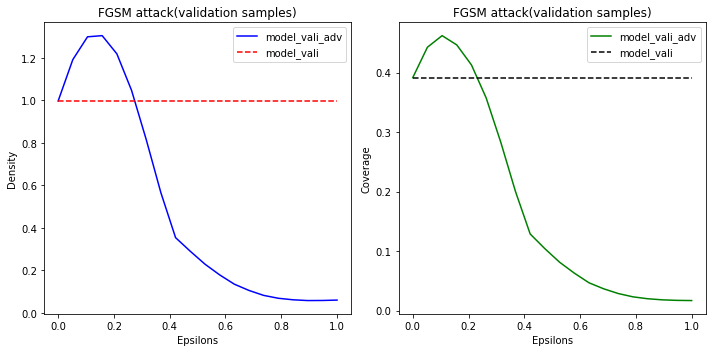

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(epsilon, vali_den, c='b', label='model_vali_adv')
ax[0].plot(epsilon, np.repeat(density_validate.cpu().numpy(), len(epsilon)), ls='--', c='r', label='model_vali')
ax[0].set_xlabel("Epsilons")
ax[0].set_ylabel("Density")
ax[0].set_title("FGSM attack(validation samples)")
ax[0].legend()
ax[1].plot(epsilon, vali_cov, c='g', label='model_vali_adv')
ax[1].plot(epsilon, np.repeat(coverage_validate.cpu().numpy(), len(epsilon)), ls='--', c='k', label='model_vali')
ax[1].set_xlabel("Epsilons")
ax[1].set_ylabel("Coverage")
ax[1].set_title("FGSM attack(validation samples)")
ax[1].legend()
fig.tight_layout()
#plt.savefig("FGSM_attack_vali_samples.png")

In [116]:
print("Coverage")
print(f"Model_dataset & validation set: coverage: {coverage_validate}")
print(f"Model_dataset & adversarial samples")
coverage_data = []
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Vali_adv_coverage: {:.5f}".format(epsilon[i], robust_accuracy[i], vali_cov[i]))
    coverage_data.append([epsilon[i], robust_accuracy[i], vali_cov[i].cpu().numpy()])

coverage_data = np.array(coverage_data)

Coverage
Model_dataset & validation set: coverage: 0.39159998297691345
Model_dataset & adversarial samples
Epsilon: 0.00000, Accuracy: 0.53%, Vali_adv_coverage: 0.39160
Epsilon: 0.05263, Accuracy: 0.55%, Vali_adv_coverage: 0.44280
Epsilon: 0.10526, Accuracy: 0.57%, Vali_adv_coverage: 0.46225
Epsilon: 0.15789, Accuracy: 0.60%, Vali_adv_coverage: 0.44665
Epsilon: 0.21053, Accuracy: 0.61%, Vali_adv_coverage: 0.41300
Epsilon: 0.26316, Accuracy: 0.63%, Vali_adv_coverage: 0.35770
Epsilon: 0.31579, Accuracy: 0.65%, Vali_adv_coverage: 0.28285
Epsilon: 0.36842, Accuracy: 0.66%, Vali_adv_coverage: 0.20020
Epsilon: 0.42105, Accuracy: 0.66%, Vali_adv_coverage: 0.12890
Epsilon: 0.47368, Accuracy: 0.62%, Vali_adv_coverage: 0.10425
Epsilon: 0.52632, Accuracy: 0.56%, Vali_adv_coverage: 0.08150
Epsilon: 0.57895, Accuracy: 0.49%, Vali_adv_coverage: 0.06325
Epsilon: 0.63158, Accuracy: 0.43%, Vali_adv_coverage: 0.04695
Epsilon: 0.68421, Accuracy: 0.39%, Vali_adv_coverage: 0.03680
Epsilon: 0.73684, Accurac

- save/write the density_data & coverage_data
- info: attack model with model_dataset -> model_dataset & adversarial samples
- attack model validataion_dataset -> model_dataset & vali_adv samples
- model_dataset & vali_dataset

In [117]:
with open('FGSM_attack_resnet50_density.dat', 'w') as newfile:
    newfile.write("# FGSM attack resnet50 model with model_dataset(22000 images)" + "\n" +
                 "# and validation_images(2100) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy Vali_adv_density" + "\n" +
                 "# Model_dataset & validation set: " + str(density_validate.cpu().numpy()) + "\n" )

with open('FGSM_attack_resnet50_coverage.dat', 'w') as newfile:
    newfile.write("# FGSM attack resnet50 model with model_dataset(22000 images)" + "\n" +
                 "# and validation_images(2100) 20 epsilon" + "\n" +
                 "# Epsilon Model_accuracy  Vali_adv_coverage" + "\n" +
                 "# Model_dataset & validation set: " + str(coverage_validate.cpu().numpy()) + "\n")
with open('FGSM_attack_resnet50_density.dat', 'a') as addfile:
    np.savetxt(addfile, density_data)
    
with open('FGSM_attack_resnet50_coverage.dat', 'a') as addfile:
    np.savetxt(addfile, coverage_data)

### Metrics for FGSM Attack - stats

- ```Batch_modelvali_metrics``` - density & coverage between model_dataset(20000) & validation_dataset(2100) in batches of 100 samples
- ```Batch_modelvali_adv_metrics``` - attack the model in batches using validation_dataset. Computed density & coverage between model_dataset & validation_adv samples

In [20]:
def model_validation_metrics_batches(real, images, labels):
    """
    Function to obtain density and coverage between model_dataset & 
    validation_dataset in batches (100 images)
    
    Parameters
    ---------------
    real: the model_dataset of (20000 images) using stratify split, torch.Tensor
    images: the validation_dataset fo (2100 images) , torch.Tensor
    labels: the labels for the validation_dataset, torch.Tensor
    
    Return
    -----------------
    bacth_model_vali_metrics: list containing density & coverage
    """
    batches = np.arange(0, 2101, 42)
    

    bacth_model_vali_metrics = []
    images = images.view(images.shape[0], -1)
    for i in range(len(batches)-1):

        # model_dataset & validation_dataset in batches
        start = batches[i]; end= batches[i+1]
        gen_validatex = images[start:end,...]
        gen_labelsx = labels[start:end]
        density_validatex = gem_build_density(real, real.shape[0], gen_validatex, 'indexflatl2')
        coverage_validatex = gem_build_coverage(real, real.shape[0], gen_validatex, 'indexflatl2')
        bacth_model_vali_metrics.append([density_validatex.cpu().numpy(), coverage_validatex.cpu().numpy()])
   
    return bacth_model_vali_metrics
        

In [17]:
def batch_validation_attack(real, images, labels, epi):
    """
    Function to obtain the density & coverage between model_dataset & validation_adv dataset
    
    - attack the model in batches of validation dataset(100 images)
    - for each epsilon value, compute the density & coverage for model_dataset & adv batch
    
    Parameters
    -------------
    real: real: the model_dataset of (20000 images) using stratify split, torch.Tensor
    images: images: the validation_dataset fo (2100 images) , torch.Tensor
    labels: the labels for the validation_dataset, torch.Tensor
    epi: np.array, epsilons for the attack
    
    Return
    -------------
    batch_model_vali_adv_metrics: list containing density & coverage
    """
    advs = []
    batch_model_vali_adv_metrics = []
    batches = np.arange(0, 2101, 42)
    images = ep.astensor(images)
    labels = ep.astensor(labels)
    for i in range(len(batches)-1):
        start = batches[i]; end= batches[i+1]
        imagesx = images[start:end,...]
        labelsx = labels[start:end]
        adv_fgsm_batch, adv_fgsm_batch_info = model_attack(attack2, original_model, imagesx, labelsx, epi)
        #advs.append(adv_fgsm_batch)
    #print(adv_fgsm_batch[0].shape)
    #print(len(advs[0]))
        for i in range(len(adv_fgsm_batch)):
            gen = adv_fgsm_batch[i].raw.view(len(adv_fgsm_batch[i]), -1)
            densityx = gem_build_density(real, real.shape[0], gen, 'indexflatl2')
            coveragex = gem_build_coverage(real, real.shape[0], gen, 'indexflatl2')
            batch_model_vali_adv_metrics.append([densityx.cpu().numpy(), coveragex.cpu().numpy()])
    
    return batch_model_vali_adv_metrics

In [22]:
realx = torch.from_numpy(np.array(X_images)).view(len(X_images), -1).to(device)
vali_attk_images = torch.from_numpy(np.array(vali_images)).to(device)
vali_attk_labels = torch.from_numpy(np.array(vali_labels)).to(device)
epsilon = np.linspace(0.0, 1, num=20)


In [23]:
Batch_modelvali_metrics = model_validation_metrics_batches(realx, vali_attk_images, vali_attk_labels)

In [25]:
with open('FGSM_attack_42batch_metrics.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(22000 images)" + "\n" +
                 "# and validation_images(2100) 20 epsilon in batches of 42 images" + "\n" +
                 "# metrics between model_dataset & validation dataset" + "\n" +
                 "# Model_vali_density Model_vali_coverage" + "\n" )
with open('FGSM_attack_42batch_metrics.dat', 'a') as newfile:
    np.savetxt(newfile, np.array(Batch_modelvali_metrics))

In [26]:
Batch_modelvali_adv_metrics = batch_validation_attack(realx, vali_attk_images, vali_attk_labels, epsilon)

In [37]:
with open('FGSM_attack_42batch_adv_metrics.dat', 'w') as newfile:
    newfile.write("# FGSM attack with model_dataset(22000 images)" + "\n" +
                 "# and validation_images(2100) 20 epsilon in batches of 42 images" + "\n" +
                 "# metrics between model_dataset & adv validation dataset" + "\n" +
                 "# Model_vali_adv_density Model_vali_adv_coverage" + "\n" )
with open('FGSM_attack_42batch_adv_metrics.dat', 'a') as newfile:
    np.savetxt(newfile, np.array(Batch_modelvali_adv_metrics))

## Attack the model using ```Boundary attack```

This attack works fine i.e, adversarial samples are created if epsilon is assigned as None

In [88]:
# manage memory
#del md_images; del md_labels; del images; del labels
#torch.cuda.empty_cache()
#print(torch.cuda.memory_allocated())

In [41]:
BdyAttack = fb.attacks.BoundaryAttack()

#### Test attack using images & labels from foolbox

This step is done to make sure adversarial samples are generated with the current version of foolbox

In [66]:
test_imgs, test_labels = ep.astensors(*samples(original_model, dataset='mnist', batchsize=16))
raw_advs, clipped_advs, success = BdyAttack(original_model, test_imgs, test_labels, epsilons=None)

In [67]:
robust_accuracy = 1 - success.float32().mean(axis=-1)
print("robust accuracy: ", robust_accuracy)

robust accuracy:  PyTorchTensor(tensor(0., device='cuda:0'))


#### Test attack using validation images

A subset of 10 images from the validation_set is used for the attack

In [42]:
vali_attk_images = ep.astensor(torch.from_numpy(np.array(vali_images)).to(device))
vali_attk_labels = ep.astensor(torch.from_numpy(np.array(vali_labels)).to(device))

In [69]:
attak = fb.attacks.BoundaryAttack()
_, _, newsuccess = BdyAttack(original_model, vali_attk_images[:10,...], vali_attk_labels[:10], epsilons=None)

In [70]:
robust_acc = 1 - newsuccess.float32().mean(axis=-1)
print("robust accuracy: ", robust_accuracy)

robust accuracy:  PyTorchTensor(tensor(0., device='cuda:0'))


### Attack the model using entire validation_dataset

- the Boundary Attack cannot be implemented if the starting images are not adversaries
- to create these adversarial samples, ```init_attack``` needs to be specified
- any of the attacks inherited from ```Minimization Attack``` can be used for this purpose
- all the initial samples should be strictly adversarial samples

##### Two different attacks were experimented
- ```SaltandPepper```, ```LinearSearchBlendedUniformNoiseAttack```
- modify the hyperparameters within these attacks to generate the adversarial samples
- the generated samples are given as the starting points for the ```BoundaryAttack```
- time complexity increases with changing these hyperparameters

In [46]:
s_attack = fb.attacks.SaltAndPepperNoiseAttack()
n_attack = fb.attacks.LinearSearchBlendedUniformNoiseAttack(directions=2500, steps=5000)
#_, adv_lsbu, _ = n_attack(original_model, vali_attk_images, vali_attk_labels, epsilons=None)

In [12]:
_, adv_bdy, adv_bdy_info = BdyAttack(original_model, vali_attk_images, vali_attk_labels, starting_points=adv_lsbu, epsilons=None)

In [32]:
print(f"acc: {1 - adv_bdy_info.float32().mean(axis=-1)}")

### Metrics

#### - entire model_dataset (67000) & validation_dataset (2100)

In [43]:
real = md_images.view(md_images.shape[0], -1).to(device)
# images from the validation set
gen_validate = vali_attk_images.raw.view(vali_attk_images.shape[0], -1)
gen_labels = vali_attk_labels
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')
print(density_validate, coverage_validate)

tensor(1.0072, device='cuda:0') tensor(0.1424, device='cuda:0')


#### - model_dataset & validation_dataset adversarials

In [16]:
gen_adv_val = adv_bdy.raw.view(adv_bdy.shape[0], -1)
model_density_val = gem_build_density(real, real.shape[0], gen_adv_val, 'indexflatl2')
model_coverage_val = gem_build_coverage(real, real.shape[0], gen_adv_val, 'indexflatl2')
print(model_density_val, model_coverage_val)

tensor(0.1557, device='cuda:0') tensor(0.0048, device='cuda:0')


In [21]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate:.5f}")
print(f"Model_dataset & validation adv (2100): density: {model_density_val:.5f}")

Density
Model_dataset & validation set: density: 1.00724
Model_dataset & validation adv(2100): density: 0.15571


### Attack the model with validation_dataset in batches

- create the adversarial samples for each batch exclusively
- use these images as starting_points for boundary attack

#### Get the adversarial starting points for each Batch
- load the 100Batch_Vali_Adv_LSBU.pt file for the saved LSBU adversarials( batch size of 100 images)
- load the 42Batch_Vali_Adv_LSBU.pt file for the saved LSBU adversarials( batch size of 42 images)

In [89]:
batches = np.arange(0, 2101, 140)
success = []
batch_adv_samples = []
for i in range(len(batches)-1):
    start = batches[i]; end= batches[i+1]
    _, batch_adv_lsbu, adv_bdy_info = n_attack(original_model, vali_attk_images[start:end,...], vali_attk_labels[start:end], epsilons=None)
    print(f"acc: {1 - adv_bdy_info.float32().mean(axis=-1)}")
    success.append(adv_bdy_info); batch_adv_samples.append(batch_adv_lsbu.raw)

acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0
acc: 0.0


In [88]:
len(np.arange(0, 2101, 140))

16

In [90]:
batch_adv_lsbu_samples = torch.stack(batch_adv_samples)
torch.save(batch_adv_lsbu_samples, '140Batch_Vali_Adv_LSBU.pt')

In [91]:
#batch_lsbu_adv = torch.load('100Batch_Vali_Adv_LSBU.pt', map_location='cpu').to(device)
batch_lsbu_adv = torch.load('140Batch_Vali_Adv_LSBU.pt', map_location='cpu').to(device)

### BoundaryAttack on the model using batches of validation_dataset

In [92]:
batch_bdy_adv = []
batch_bdy_info = []
for i in range(len(batches)-1):
    start = batches[i]; end= batches[i+1]
    _, adv_bdy, adv_bdy_info = BdyAttack(original_model, vali_attk_images[start:end,...], vali_attk_labels[start:end], 
                                         starting_points=batch_lsbu_adv[i], epsilons=None)
    batch_bdy_adv.append(adv_bdy); batch_bdy_info.append(adv_bdy_info)

### Metrics

- #### model_dataset & validation_dataset in batches
- #### model_deataset & validation adv in batches

In [93]:
batch_density_validate = []
batch_coverage_validate = []
batch_model_density = []
batch_model_coverage = []

for i in range(len(batches)-1):
    # model_dataset & validation_dataset in batches
    start = batches[i]; end= batches[i+1]
    bth_val_imgs = vali_attk_images[start:end,...]
    gen_validatex = bth_val_imgs.raw.view(bth_val_imgs.shape[0], -1)
    gen_labelsx = vali_attk_labels[start:end].raw
    density_validatex = gem_build_density(real, real.shape[0], gen_validatex, 'indexflatl2')
    coverage_validatex = gem_build_coverage(real, real.shape[0], gen_validatex, 'indexflatl2')
    
    # model_dataset & validation_dataset adversarials in batches
    gen_adv_valx = batch_bdy_adv[i].raw.view(batch_bdy_adv[i].shape[0], -1)
    model_density_valx = gem_build_density(real, real.shape[0], gen_adv_valx, 'indexflatl2')
    model_coverage_valx = gem_build_coverage(real, real.shape[0], gen_adv_valx, 'indexflatl2')
    
    batch_density_validate.append(density_validatex)
    batch_coverage_validate.append(coverage_validatex)
    batch_model_density.append(model_density_valx)
    batch_model_coverage.append(model_coverage_valx)


In [95]:
with open('Boundary_attack_140batch_metrics.dat', 'w') as newfile:
    newfile.write("# Boundary attack with validation_dataset(2100 images)" + "\n" +
                 "# and metrics using model_dataset(67000)" + "\n" +
                 "# Model_dataset & validation set: density: " + str(density_validate.cpu().numpy()) + "\n" +
                 "# Model_dataset & validation adv (2100): density: " + str(0.15571429) + "\n" +
                 "# Model_dataset & validation set: coverage: " + str(coverage_validate.cpu().numpy()) + "\n" +
                 "# Model_dataset & validation adv (2100): coverage: " + str(0.0047275405) + "\n" + 
                 "# batch_no model_val_density model_val_adv_density model_val_coverage model_val_adv_coverage" + "\n")
    
with open('Boundary_attack_140batch_metrics.dat', 'a') as nefile:
    for i in range (len(batch_density_validate)):
        nefile.write(str(i)+ " " + str(batch_density_validate[i].cpu().numpy())+ " " + str(batch_model_density[i].cpu().numpy())+ " " +
                    str(batch_coverage_validate[i].cpu().numpy()) + " " + str(batch_model_coverage[i].cpu().numpy()) + "\n")

## The End

In [1]:
import medmnist